In [3]:
import os
import cv2

def load_image(img_path, img_size):
    image = cv2.imread(img_path)
    height, width, _ = image.shape
    diff = height-width
    if diff > 0:
        image = cv2.copyMakeBorder(image, 0, 0, diff//2, diff//2, borderType=cv2.BORDER_CONSTANT, value=[255, 255, 255])
    elif diff < 0:
        image = cv2.copyMakeBorder(image, -diff//2, -diff//2, 0, 0, borderType=cv2.BORDER_CONSTANT, value=[255, 255, 255])
    image = cv2.resize(image, (img_size, img_size), interpolation=cv2.INTER_AREA)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # image = np.expand_dims(image, -1)
    return image

def angle_difference(a, b):
    return 180 - abs(abs(a - b) - 180)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import pytorch_lightning as pl
import torchmetrics as tm
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import numpy as np

import matplotlib.pyplot as plt

import random

class RandomResizedCenterCrop(torch.nn.Module):
    def __init__(self, max_crop_ratio=0.8):
        super().__init__()
        self.max_crop_ratio = max_crop_ratio

    def forward(self, img):
        _, H, W = img.size()
        size = torch.LongTensor([H, W])

        ratio = torch.rand(1) * (1-self.max_crop_ratio) + self.max_crop_ratio
        crop_size = (size * ratio).int().tolist()

        img = TF.center_crop(img, crop_size)
        img = TF.resize(img, size.tolist(), interpolation=transforms.InterpolationMode.BILINEAR)

        return img

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(max_crop_ratio={self.max_crop_ratio})"

class ToiletsTrain(data.Dataset):
    def __init__(self, classes, split='train', img_size=100):
        self.classes = classes
        self.folder = f'../toilets/{split}/'
        self.files = os.listdir(self.folder)[1:] # remove A_wrong
        self.img_size = img_size
        self.split = split

        self.transforms = transforms
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(0.1, 0.1, 0.1, 0.1)
        ])
        self.resize = RandomResizedCenterCrop(0.75)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        name = self.files[idx]
        img = load_image(self.folder + name, self.img_size)
        img = np.moveaxis(img, 2, 0)
        img = (img / 255) * 2 - 1
        img = torch.tensor(img).float()
        img = self.transform(img)

        rot = random.choice(self.classes)
        img = TF.rotate(img, rot, interpolation=transforms.InterpolationMode.BILINEAR, fill=1)

        img = self.resize(img)

        return img, rot//(360//len(self.classes))

class ToiletsEval(data.Dataset):
    def __init__(self, classes, split, n_samples=None, img_size=100, seed=0):
        self.classes = classes
        self.folder = f'../toilets/{split}/'
        self.files = os.listdir(self.folder)[1:] # remove A_wrong
        self.files = [f+'@'+str(c) for f in self.files for c in classes]
        if n_samples != None:
            random.seed(seed)
            self.files = random.sample(self.files, n_samples)
        self.img_size = img_size
        self.split = split

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        name = self.files[idx]
        name, rot = name.split('@')
        rot = int(rot)

        img = load_image(self.folder + name, self.img_size)
        img = np.moveaxis(img, 2, 0)
        img = (img / 255) * 2 - 1
        img = torch.tensor(img).float()

        img = TF.rotate(img, rot, interpolation=transforms.InterpolationMode.BILINEAR, fill=1)

        return img, rot//(360//len(self.classes))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


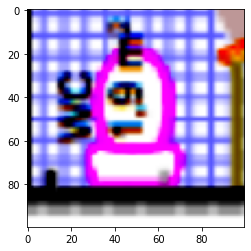

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


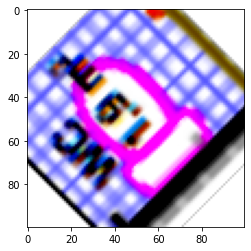

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


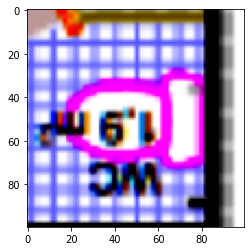

In [5]:
classes = range(0, 360, 45)

t = ToiletsEval(classes, 'val', None)
# t = ToiletsTrain(classes)
for i in range(3):
    im, rot = t[i]
    print(rot)
    plt.imshow(im.permute(1,2,0))
    # plt.imshow(im.permute(1,2,0), cmap='gray')
    plt.show()

In [17]:
def labels_to_angles(labels, classes):
    return labels*(360//len(classes))

def tensor_angle_diff(preds, gt):
    return 180 - torch.abs(torch.abs(preds - gt) - 180)

testloader = data.DataLoader(ToiletsEval(classes, 'test', 1000), batch_size=4, num_workers=1)
x, y = next(iter(testloader))

gt_angles = labels_to_angles(y, classes)
print(gt_angles)
preds = torch.LongTensor([225, 90, 135, 90])
print(preds)
print(tensor_angle_diff(gt_angles, preds))

tensor([135, 225, 135,  45])
tensor([225,  90, 135,  90])
tensor([ 90, 135,   0,  45])


In [6]:
import torchvision.models as models

class Net(pl.LightningModule):

    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.n_classes = len(classes)

        self.net = models.convnext_tiny(pretrained=True)
        in_features = self.net.classifier[2].in_features
        self.net.classifier[2] = nn.Linear(in_features, self.n_classes)

        self.accuracy = tm.Accuracy()


    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        ce_loss = F.cross_entropy(logits, y)

        preds = torch.argmax(logits, dim=1)
        pred_angles = labels_to_angles(preds, self.classes)
        gt_angles = labels_to_angles(preds, self.classes)
        angle_loss = tensor_angle_diff(pred_angles, gt_angles)/360

        # loss += angle_diffs/360

        self.log("train_ce_loss", ce_loss, prog_bar=True)
        self.log("train_angle_loss", angle_loss, prog_bar=True)

        return ce_loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        ce_loss = F.cross_entropy(logits, y)

        preds = torch.argmax(logits, dim=1)
        pred_angles = labels_to_angles(preds, self.classes)
        gt_angles = labels_to_angles(preds, self.classes)
        angle_loss = tensor_angle_diff(pred_angles, gt_angles)/360
        self.accuracy(preds, y)

        self.log("val_acc", self.accuracy, prog_bar=True)
        self.log("val_ce_loss", ce_loss, prog_bar=True)
        self.log("val_angle_loss", angle_loss, prog_bar=True)
        self.log("val_loss", ce_loss + angle_loss, prog_bar=True)

        return loss
    
    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)
 
    def configure_optimizers(self):
        return optim.Adam(self.parameters())

In [14]:
name = 'toilets-classification-baseline-bgr'
classes = range(0, 360, 45)
model = Net(classes)

trainloader = data.DataLoader(ToiletsTrain(classes), batch_size=64, shuffle=True, num_workers=1)
valloader = data.DataLoader(ToiletsEval(classes, 'val', 1000), batch_size=64, num_workers=6)
# valloader = data.DataLoader(ToiletsTrain(classes), batch_size=64, num_workers=6)

logger = pl.loggers.TensorBoardLogger('../lightning_logs', name=name, version=1)
trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=-1,
    logger=logger,
    log_every_n_steps=20,
    callbacks=[
        pl.callbacks.progress.TQDMProgressBar(refresh_rate=20),
        # pl.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=3),
        pl.callbacks.ModelCheckpoint(monitor="val_loss", save_last=True, save_top_k=3, filename='{epoch}-{val_loss:.3f}-{val_acc:.3f}')
    ],
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
trainer.fit(model, trainloader, valloader)

/mnt/c/Users/joaodavid/Desktop/CubiCasa5k/venv/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:608: UserWarning: Checkpoint directory ../lightning_logs/toilets-classification-baseline-bgr/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type     | Params
--------------------------------------
0 | net      | ConvNeXt | 27.8 M
1 | accuracy | Accuracy | 0     
--------------------------------------
27.8 M    Trainable params
0         Non-trainable params
27.8 M    Total params
111.305   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

: 

In [17]:
testloader = data.DataLoader(ToiletsEval('test', 1000), batch_size=1, num_workers=1)
import time
start = time.time()
for i in range(1):
    trainer.test(model, testloader, ckpt_path=f'../lightning_logs/{name}/version_1/checkpoints/epoch=13-val_loss=5.885-val_acc=0.003.ckpt')
print((time.time() - start)/5)


Restoring states from the checkpoint path at ../lightning_logs/toilets-classification-baseline-bgr/version_1/checkpoints/epoch=13-val_loss=5.885-val_acc=0.003.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ../lightning_logs/toilets-classification-baseline-bgr/version_1/checkpoints/epoch=13-val_loss=5.885-val_acc=0.003.ckpt
/mnt/c/Users/joaodavid/Desktop/CubiCasa5k/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc           0.003000000026077032
        val_loss             5.886162281036377
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
6.619189071655273


In [18]:
testloader = data.DataLoader(ToiletsEval('test', 1000), batch_size=4, num_workers=1)
all_preds = []
all_gt = []
model.eval()
with torch.no_grad():
    for x, y in testloader:
        preds = model(x).argmax(1).numpy()
        all_preds.append(list(preds))
        all_gt.append(y.numpy())

all_preds = torch.as_tensor(np.array([item for sublist in all_preds for item in sublist]))
all_gt = torch.as_tensor(np.array([item for sublist in all_gt for item in sublist]))

In [19]:
classes = tuple(str(i) for i in range(360))

In [21]:
import seaborn as sn

cm = tm.ConfusionMatrix(len(classes))
matrix = cm(all_preds, all_gt).numpy()
matrix = np.vstack((matrix[2], matrix[:2], matrix[3:]))
matrix = matrix[:, [2, 0, 1, *range(3, len(matrix))]]

plt.figure(figsize=(10, 10))
ax = plt.axes()
ax = sn.heatmap(matrix, annot=True, fmt='g', cmap='Blues', linewidth=.5, xticklabels=classes, yticklabels=classes, ax=ax)
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.show()

KeyboardInterrupt: 

In [45]:
tp = np.diag(matrix)
acc = tp/np.sum(matrix, axis=1)
precision = tp/np.sum(matrix, axis=0)

print('class,'+ ','.join(classes))
print('accuracy,'+ ','.join([f'{el*100:4.2f}' for el in acc]))
print('precision,'+ ','.join([f'{el*100:4.2f}' for el in precision]))

class,slide,rollup,none,double_d,double_u,opposite_ul_dl,opposite_ul_dr,opposite_ur_dl,opposite_ur_dr,single_dl,single_dr,single_ul,single_ur
accuracy,70.45,77.08,66.80,91.67,91.67,93.75,91.03,92.31,95.92,97.39,97.93,97.04,98.46
precision,67.83,77.89,78.02,90.83,87.61,97.18,97.26,98.63,97.25,95.55,94.53,94.47,94.02


In [34]:
# torch.save(model.state_dict(), 'CONVNEXT-TINY.pth')

class Net(nn.Module):

    def __init__(self, classes):
        super().__init__()
        self.n_classes = len(classes)

        self.backbone = models.convnext_tiny(pretrained=False)

        self.fc1 = nn.Linear(1000, self.n_classes)


    def forward(self, x):
        x = self.backbone(x).flatten(1)
        x = self.fc1(x)
        return x


model2 = Net(classes)
model2.load_state_dict(torch.load('CONVNEXT-TINY.pth'))

<All keys matched successfully>

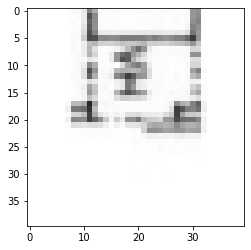

Expected: 3: Door Slide Beside
Predicted: 14: Single_ur


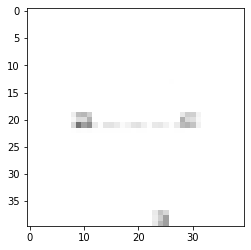

Expected: 3: Door Slide Beside
Predicted: 0: Door None Beside


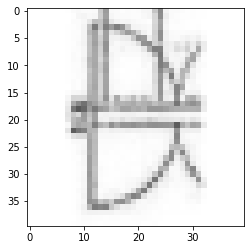

Expected: 7: Opposite_ul_dl
Predicted: 11: Single_dl


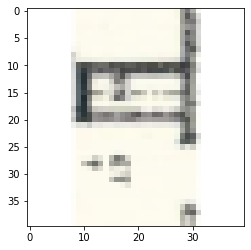

Expected: 1: Door ParallelSlide Beside
Predicted: 0: Door None Beside


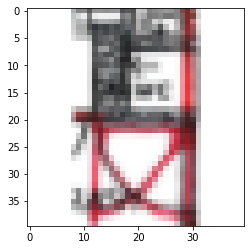

Expected: 11: Single_dl
Predicted: 12: Single_dr


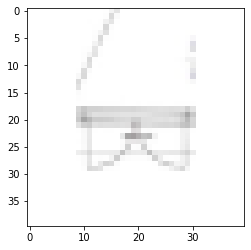

Expected: 5: Double_d
Predicted: 12: Single_dr


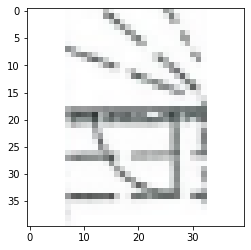

Expected: 14: Single_ur
Predicted: 12: Single_dr


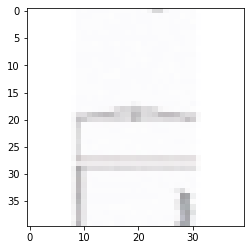

Expected: 6: Double_u
Predicted: 0: Door None Beside


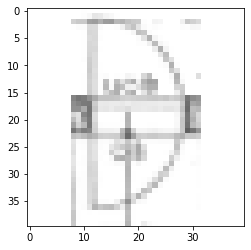

Expected: 7: Opposite_ul_dl
Predicted: 13: Single_ul


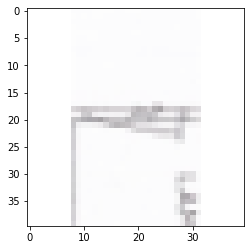

Expected: 11: Single_dl
Predicted: 0: Door None Beside


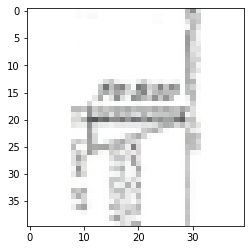

Expected: 12: Single_dr
Predicted: 14: Single_ur


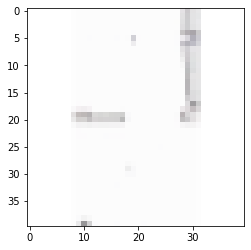

Expected: 3: Door Slide Beside
Predicted: 0: Door None Beside


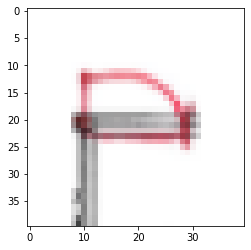

Expected: 13: Single_ul
Predicted: 14: Single_ur


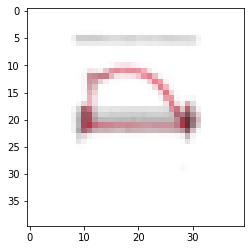

Expected: 13: Single_ul
Predicted: 14: Single_ur


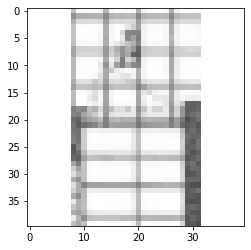

Expected: 0: Door None Beside
Predicted: 14: Single_ur


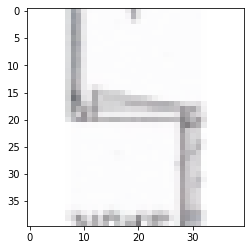

Expected: 14: Single_ur
Predicted: 0: Door None Beside


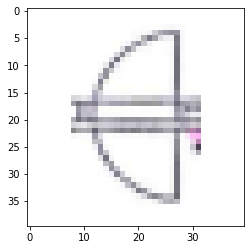

Expected: 10: Opposite_ur_dr
Predicted: 14: Single_ur


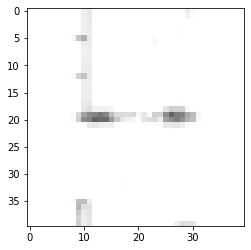

Expected: 4: Door Zfold Beside
Predicted: 0: Door None Beside


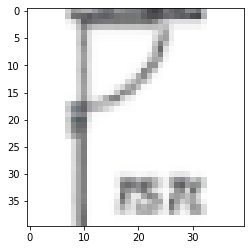

Expected: 12: Single_dr
Predicted: 13: Single_ul


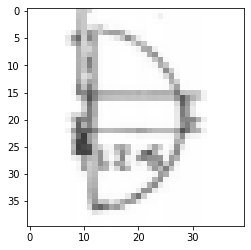

Expected: 7: Opposite_ul_dl
Predicted: 13: Single_ul


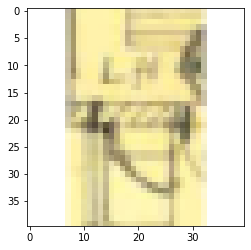

Expected: 12: Single_dr
Predicted: 11: Single_dl


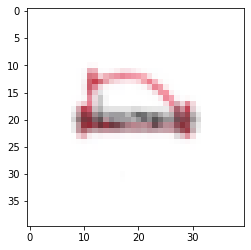

Expected: 13: Single_ul
Predicted: 14: Single_ur


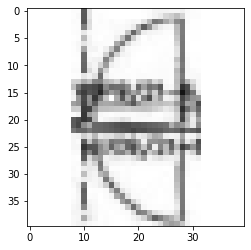

Expected: 10: Opposite_ur_dr
Predicted: 12: Single_dr


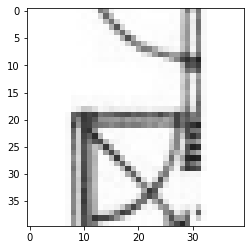

Expected: 11: Single_dl
Predicted: 13: Single_ul


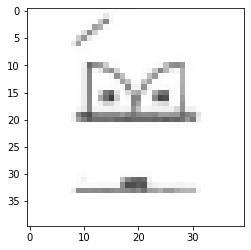

Expected: 6: Double_u
Predicted: 14: Single_ur


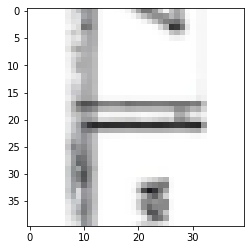

Expected: 0: Door None Beside
Predicted: 11: Single_dl


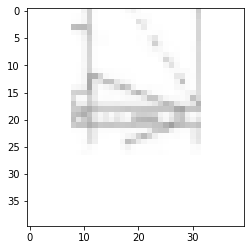

Expected: 10: Opposite_ur_dr
Predicted: 12: Single_dr


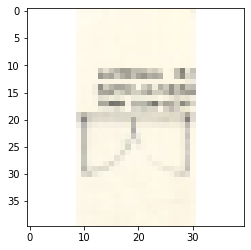

Expected: 5: Double_d
Predicted: 0: Door None Beside


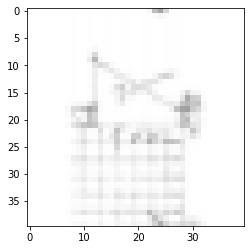

Expected: 14: Single_ur
Predicted: 11: Single_dl


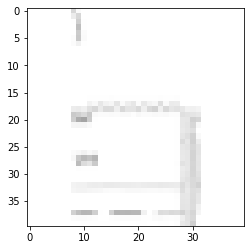

Expected: 4: Door Zfold Beside
Predicted: 12: Single_dr


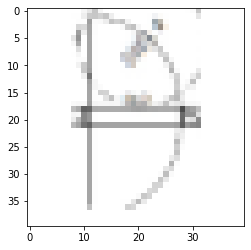

Expected: 7: Opposite_ul_dl
Predicted: 11: Single_dl


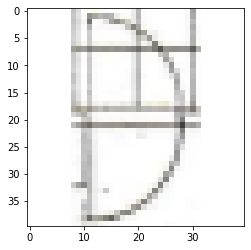

Expected: 7: Opposite_ul_dl
Predicted: 11: Single_dl


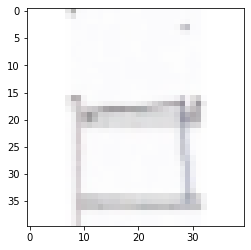

Expected: 13: Single_ul
Predicted: 0: Door None Beside


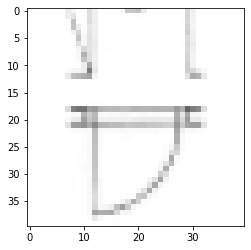

Expected: 12: Single_dr
Predicted: 11: Single_dl


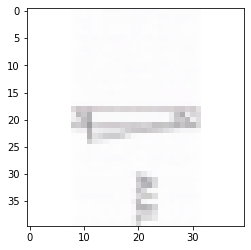

Expected: 12: Single_dr
Predicted: 11: Single_dl


In [49]:
with torch.no_grad():
    for idx, (img, label) in enumerate(iter(testloader)):
        if preds[idx] != targets[idx]:
            img_rgb = ((img.numpy() + 1)/2 * 255).astype(np.int)[0]
            img_rgb = np.moveaxis(img_rgb, 0, 2)
            plt.imshow(img_rgb)
            plt.show()
            print(f'Expected: {label.item()}: {classes[label]}')
            predict = model(img).argmax().item()
            print(f'Predicted: {predict}: {classes[predict]}')
            
        

In [27]:
example = iter(testloader)

In [40]:
testloader = data.DataLoader(Doors('test'), batch_size=1, num_workers=1)
testiter = iter(testloader)

Expected: 4: opposite_ul_dl
Got: 4: opposite_ul_dl


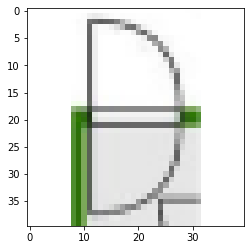

In [50]:
example = next(testiter)
img, label = example
img_rgb = ((img.numpy() + 1)/2 * 255).astype(int)[0]
img_rgb = np.moveaxis(img_rgb, 0, 2)
print(f'Expected: {label[0]}: {classes[label]}')
model2.eval()
predict = model(img).argmax().item()
print(f'Got: {predict}: {classes[predict]}')
plt.imshow(img_rgb)


In [42]:
model.eval()
predict = model(img).argmax().item()
print(f'{predict}: {classes[predict]}')

1: none
